# SetUP

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ac796820-45f2-c309-b7cd-1f22734dbf7c)


In [2]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 36.6 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.7.1+cu101 which is incompatible.
torchaudio 0.11.0+cu113 req

# Import Library & Define

In [3]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import glob
from google.colab import output
InteractiveShell.ast_node_interactivity = "all"

# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')

# Perceptor

In [4]:
import clip
clip.available_models()

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 225MiB/s]


# Generator

In [5]:
import io
import os, sys
import requests
import PIL
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from dall_e import map_pixels, unmap_pixels, load_model

target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')

# Text input

In [6]:
text_input = "a beautiful and mysterious castle designed by Escher" 
tau_value =1.2

# Latent coordinate

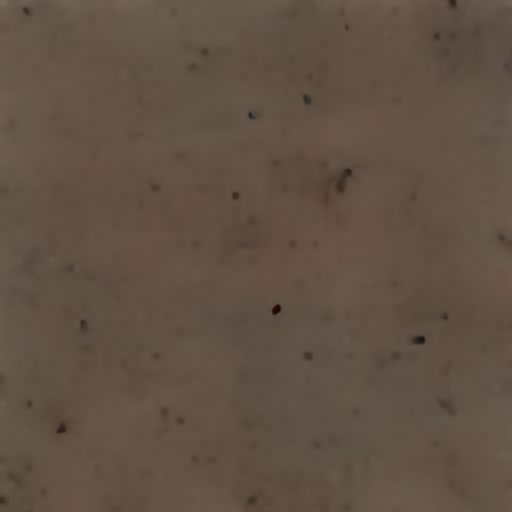

In [7]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

    def forward(self):
      # normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)
      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1, tau=tau_value).view(1, 8192, 64, 64)
      return normu

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0
tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))

# Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


##########################################################  

[0, tensor([-1.9844], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 0


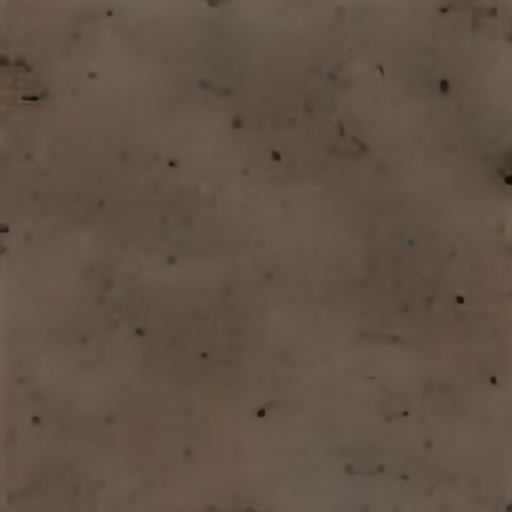



##########################################################  

[0, tensor([-4.1406], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 100


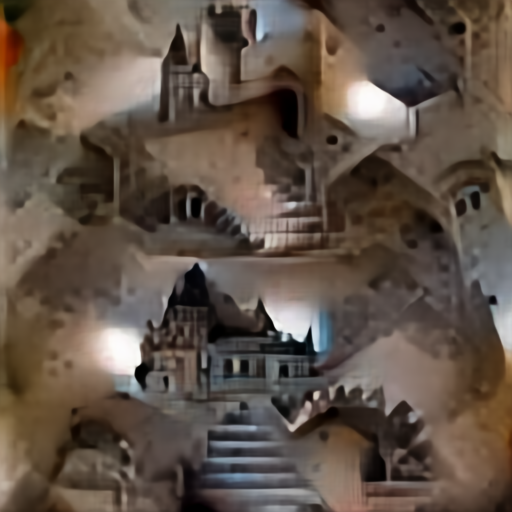



##########################################################  

[0, tensor([-4.2617], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 200


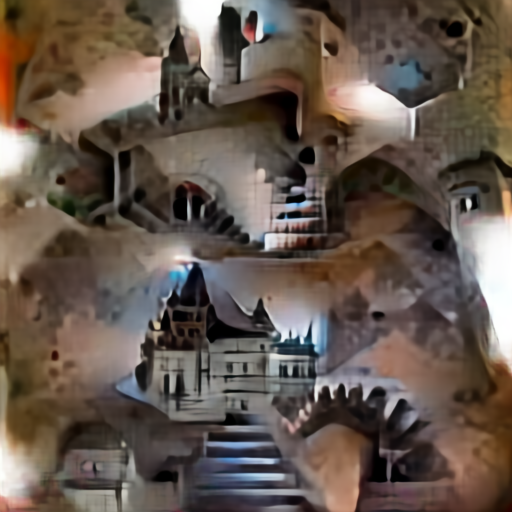



##########################################################  

[0, tensor([-4.2812], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 300


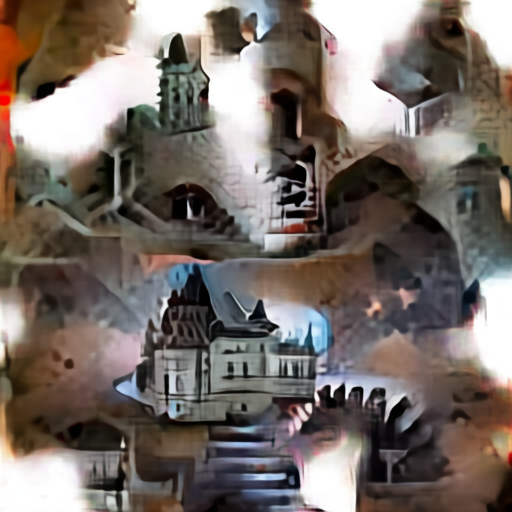

In [ ]:
def checkin(loss):
  print('''########################################################## ''',loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  # output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')
  into = nom(into)
  iii = perceptor.encode_image(into)
  llls = lats()
  lat_l = 0
  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  if itt % 100 == 0:
    checkin(loss1)
    shutil.copy('./3.png', './images/%s.png'%str(int(itt/100)).zfill(6))

import shutil

if os.path.isdir('images'):
    shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

itt = 0
for asatreat in range(1100):
  train(itt)
  itt+=1

# Make movie

In [ ]:
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

!ffmpeg -r 2 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p output.mp4